### Алгоритмы кластеризации

1. K-Means (1 балл)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

(427, 640, 3)


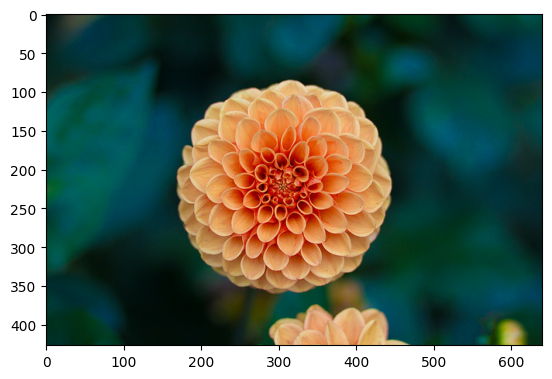

In [10]:
img = plt.imread("flower.png")[:,:,:3]
print(img.shape)
_ = plt.imshow(img)

In [11]:
X = img.reshape((-1,3))
print(X.shape)

(273280, 3)


In [31]:
from scipy.spatial import distance

class KMeans(object):
    def __init__(self, n_clusters, max_iter, seed=0, tol=0.001):
        # число кластеров
        self.n_clusters = n_clusters
        # максимальное число итераций (на случай, если будет долго сходиться)
        self.max_iter = max_iter
        # array-like of shape (n_clusters, n_features) – в эту переменную сохраняются координаты центроидов
        self.centroids = None
        # массив со значениями функции ошибки на каждой итерации
        self.losses = []
        # зерно генератора случайных чисел
        self.seed = seed
        # точность, с которой мы смотрим на изменение положения центроидов
        self.tol = tol

    def distances(self, X):
        '''
        Returns distance from each sample to all centroids
        :param X: array-like of shape (n_samples, n_features)
            Training instances to cluster
        :return dist: array-like of shape (n_samples, n_clusters)
            Matrix of distances
        '''
        dist = distance.cdist(X, self.centroids, 'euclidean')
        return dist

    def loss(self, dist):
        '''
        :param dist: array-like of shape (n_samples, n_clusters)
            Matrix of distances
        :return loss: float
            Value of the loss function
        '''
        loss = np.sum(list(map(lambda distances: np.min(distances ** 2), dist))) / len(dist)
        return loss

    def initialize(self, X):
        '''
        Initialize centroids
        :param X: array-like of shape (n_samples, n_features)
            Training instances to cluster
        '''
        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters)]


    def fit_predict(self, X):
        '''
        Implements Lloyd's algorithm
        :param X: array-like of shape (n_samples, n_features)
            Training instances to cluster
        :return labels : ndarray of shape (n_samples,)
            Index of the cluster each sample belongs to.
        '''
        # инициализируем генератор случайных чисел
        np.random.seed(self.seed)

        # инициализируем центроиды
        self.initialize(X)

        n_samples, n_features = X.shape
        labels = []
        iteration = 0
        next_centroids = self.centroids

        while (not np.allclose(self.centroids, next_centroids, atol=self.tol) and iteration < self.max_iter) or iteration == 0:
            self.centroids = np.copy(next_centroids)
            dist = self.distances(X)
            self.losses.append(self.loss(dist))
            labels = []
            clasters_sum = [np.zeros(n_features) for _ in range(self.n_clusters)]
            clasters_size = np.zeros(self.n_clusters)
            for i in range(n_samples):
                label = np.argmin(dist[i])
                labels.append(label)
                clasters_sum[label] += X[i]
                clasters_size[label] += 1

            for i in range(self.n_clusters):
                next_centroids[i] = clasters_sum[i] / clasters_size[i]
            iteration += 1

        return labels

Запустим кластеризацию на наших данных

In [32]:
cls = KMeans(n_clusters=8, max_iter=100, seed=0)
y_pred = cls.fit_predict(X)
losses = cls.losses
centroids = cls.centroids

Посмотрим, как убывала функция ошибки

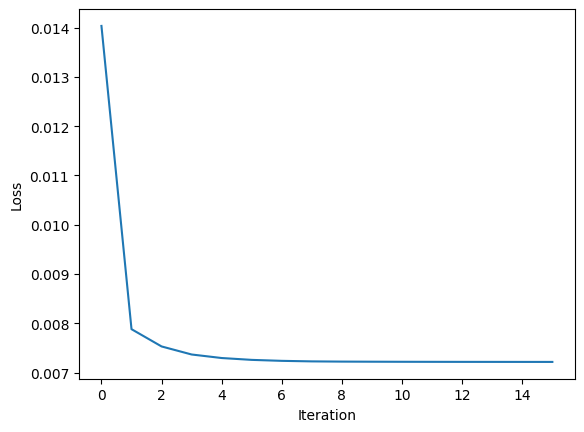

In [33]:
_ = plt.plot(losses)
_ = plt.xlabel('Iteration')
_ = plt.ylabel('Loss')

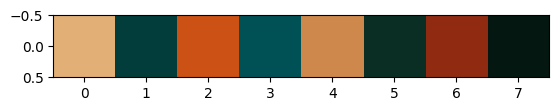

In [34]:
_ = plt.imshow([centroids])

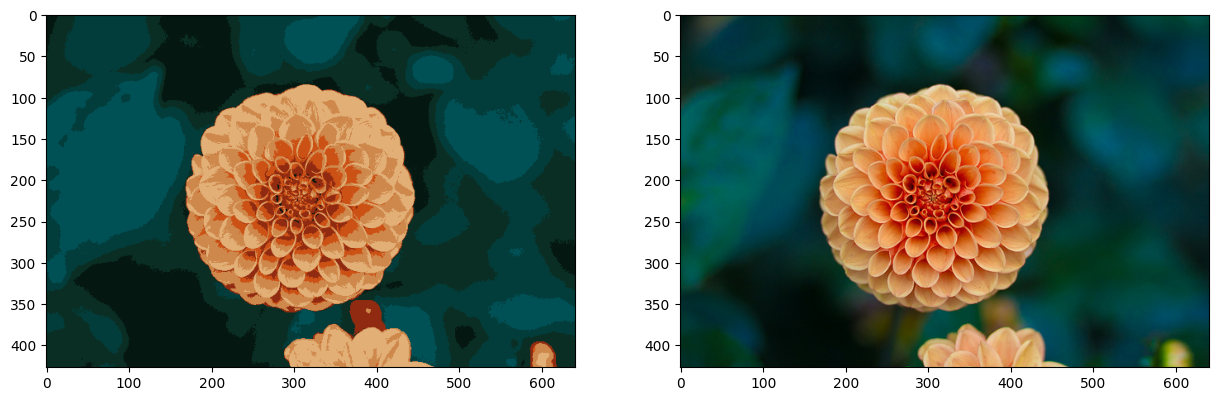

In [18]:
Y = [centroids[y_pred[i]] for i in range(len(X))]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
_ = ax1.imshow(np.array(Y).reshape(img.shape))
_ = ax2.imshow(img)

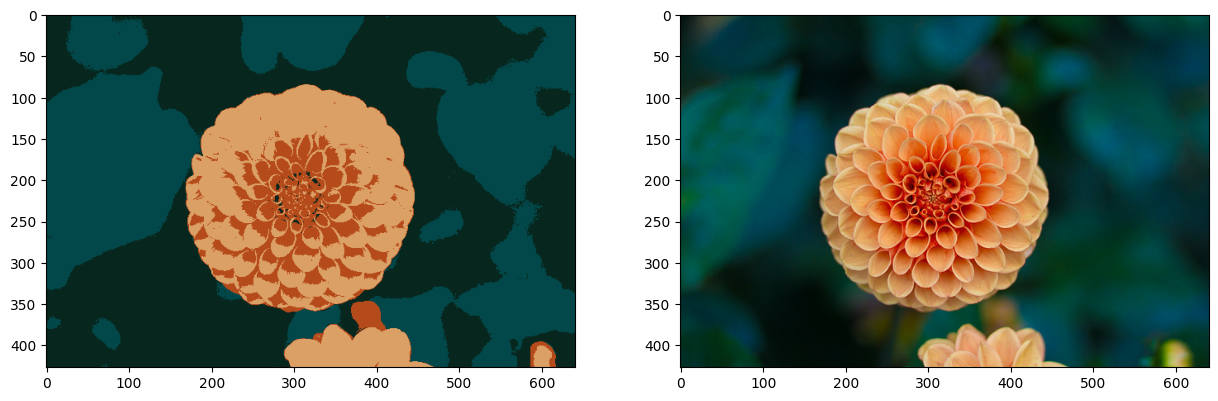

In [19]:
cls = KMeans(n_clusters=4, max_iter=100, seed=0)
y_pred = cls.fit_predict(X)
losses = cls.losses
centroids = cls.centroids

Y = centroids[y_pred, :]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
_ = ax1.imshow(np.array(Y).reshape(img.shape))
_ = ax2.imshow(img)

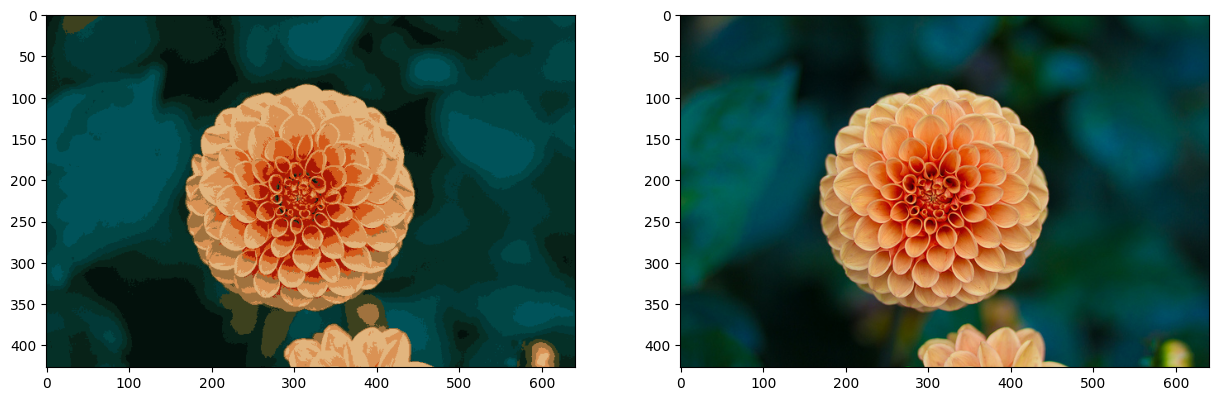

In [20]:
cls = KMeans(n_clusters=12, max_iter=100, seed=0)
y_pred = cls.fit_predict(X)
losses = cls.losses
centroids = cls.centroids

Y = centroids[y_pred, :]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
_ = ax1.imshow(np.array(Y).reshape(img.shape))
_ = ax2.imshow(img)

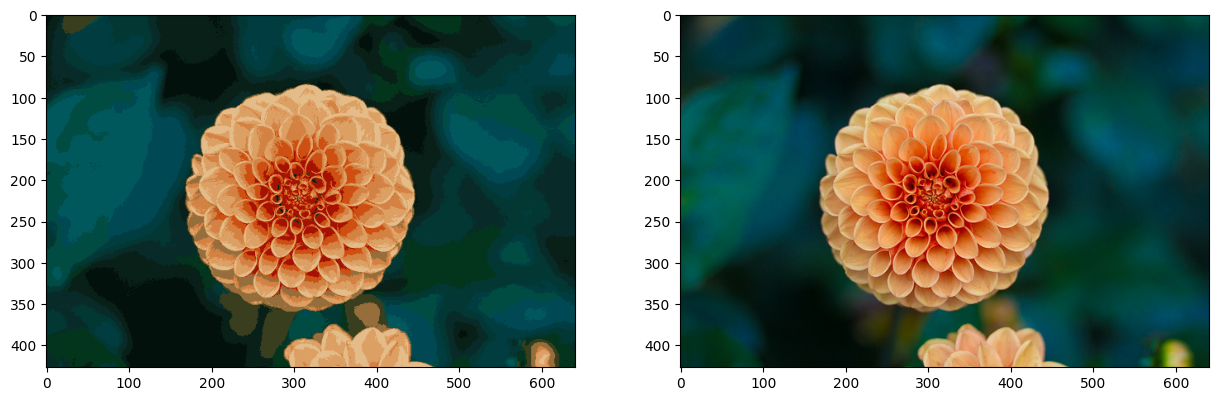

In [21]:
cls = KMeans(n_clusters=16, max_iter=100, seed=0)
y_pred = cls.fit_predict(X)
losses = cls.losses
centroids = cls.centroids

Y = centroids[y_pred, :]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
_ = ax1.imshow(np.array(Y).reshape(img.shape))
_ = ax2.imshow(img)

Чем больше количество кластеров, тем более четкая
картинка.

2. Иерархическая кластеризация (1 балл)

2.1. Реализуйте функцию `distance_matrix`, вычисляющую матрицу попарных расстояний между точками.

In [22]:
def distance_matrix(X):
    '''
    Compute matrix of pair-wise distances between samples
    :param X: array-like of shape (n_samples, n_features)
        Samples
    :return D: array-like of shape (n_samples, n_samples)
        Matrix of pair-wise distances between samples
    '''
    D = distance.cdist(X, X, 'euclidean')
    return D

2.2. Реализуйте функцию `linkage`.

In [23]:
def linkage(D):
    '''
    :param D: array-like of shape (n_samples, n_samples)
            Matrix of pair-wise distances between samples
    :return linkage: Linkage matrix
    '''
    linkage = []
    n_samples, _ = D.shape
    clusters = [(i, [i]) for i in range(n_samples)]
    D1 = D.copy()
    k = 0
    while len(clusters) > 1:
        min_dist = np.inf
        c1_ind, c2_ind = -1, -1
        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                dist = D1[i][j]
                if dist < min_dist:
                    min_dist = dist
                    c1_ind, c2_ind = i, j

        c1, c2 = clusters[c1_ind][0], clusters[c2_ind][0]
        number_new_cluster = n_samples + k
        new_cluster = clusters[c1_ind][1] + clusters[c2_ind][1]
        D1 = np.delete(np.delete(D1, c1_ind, axis=0), c1_ind, axis=1)
        D1 = np.delete(np.delete(D1, c2_ind - 1, axis=0), c2_ind - 1, axis=1)
        clusters.pop(c1_ind)
        clusters.pop(c2_ind - 1)
        new_distances = []
        for i in range(len(clusters)):
            new_distances.append(np.mean([D[x][y] for x in clusters[i][1] for y in new_cluster]))
        D1 = np.vstack([D1, new_distances])
        new_distances.append(0.)
        D1 = np.hstack([D1, np.expand_dims(new_distances, axis=1)])
        clusters.append((number_new_cluster, new_cluster))
        linkage.append([c1, c2, min_dist, len(new_cluster)])
        k += 1
    return linkage

**Проверка 1**

In [24]:
# Нам дана матрица расстояний
D = np.array([[0.  , 0.74, 0.85, 0.54, 0.83, 0.92, 0.89],
              [0.74, 0.  , 1.59, 1.35, 1.2 , 1.48, 1.55],
              [0.85, 1.59, 0.  , 0.63, 1.13, 0.69, 0.73],
              [0.54, 1.35, 0.63, 0.  , 0.66, 0.43, 0.88],
              [0.83, 1.2 , 1.13, 0.66, 0.  , 0.72, 0.55],
              [0.92, 1.48, 0.69, 0.43, 0.72, 0.  , 0.8 ],
              [0.89, 1.55, 0.73, 0.88, 0.55, 0.8 , 0.  ]])

# кластеризуем
Z = linkage(D)

# и напечатаем что получилось
print(np.array(Z))

[[ 3.    5.    0.43  2.  ]
 [ 4.    6.    0.55  2.  ]
 [ 2.    7.    0.66  3.  ]
 [ 0.    1.    0.74  2.  ]
 [ 8.    9.    0.82  5.  ]
 [10.   11.    1.12  7.  ]]


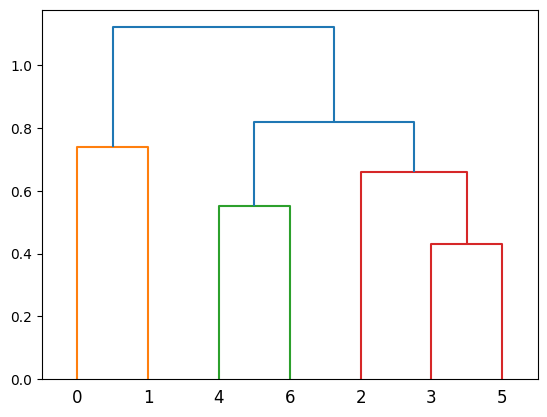

In [25]:
# для построения дендрограммы воспользуемся функцией из библиотеки scipy
from scipy.cluster.hierarchy import dendrogram
_ = dendrogram(Z)

**Проверка 2**

[[ 0.         17.          0.19        2.        ]
 [ 2.          8.          0.21        2.        ]
 [ 3.          5.          0.22        2.        ]
 [ 4.         10.          0.3         2.        ]
 [14.         22.          0.355       3.        ]
 [ 1.         20.          0.36        3.        ]
 [15.         19.          0.42        2.        ]
 [ 9.         13.          0.48        2.        ]
 [ 6.         18.          0.49        2.        ]
 [12.         21.          0.56        3.        ]
 [11.         25.          0.56333333  4.        ]
 [ 7.         30.          0.6325      5.        ]
 [16.         26.          0.705       3.        ]
 [28.         32.          0.78166667  5.        ]
 [24.         29.          0.80666667  6.        ]
 [23.         27.          0.87        4.        ]
 [31.         34.          0.995      11.        ]
 [33.         36.          1.05890909 16.        ]
 [35.         37.          1.184375   20.        ]]


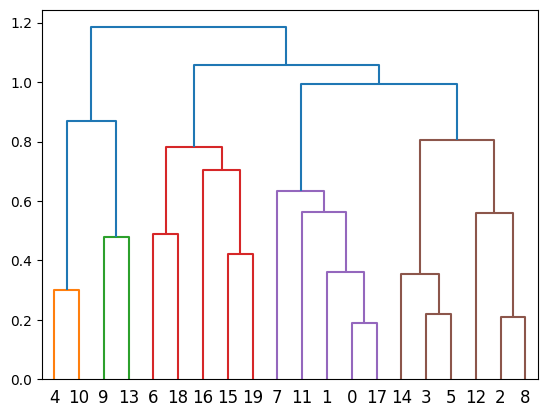

In [26]:
D = np.array([
    [0.  , 0.43, 0.93, 0.85, 0.94, 0.7 , 0.95, 0.79, 0.89, 1.34, 0.8 , 0.64, 1.42, 1.37, 0.86, 1.2 , 0.49, 0.19, 1.48, 0.86],
    [0.43, 0.  , 0.66, 0.7 , 1.48, 0.58, 0.7 , 0.55, 0.68, 1.45, 1.31, 0.37, 1.24, 1.69, 0.91, 1.28, 1.04, 0.29, 0.94, 1.05],
    [0.93, 0.66, 0.  , 1.01, 1.42, 0.8 , 0.76, 1.18, 0.21, 1.18, 1.35, 0.82, 0.68, 0.85, 0.75, 1.01, 0.93, 1.03, 0.6 , 0.91],
    [0.85, 0.7 , 1.01, 0.  , 1.02, 0.22, 0.89, 0.91, 0.79, 1.47, 1.04, 1.51, 0.71, 1.63, 0.34, 1.05, 1.24, 0.56, 1.09, 1.25],
    [0.94, 1.48, 1.42, 1.02, 0.  , 1.46, 1.48, 0.95, 1.44, 1.08, 0.3 , 1.29, 1.28, 0.65, 1.  , 0.8 , 0.8 , 0.92, 1.48, 0.65],
    [0.7 , 0.58, 0.8 , 0.22, 1.46, 0.  , 0.77, 1.  , 0.65, 1.25, 1.27, 1.36, 0.81, 1.56, 0.37, 0.98, 1.17, 0.68, 0.88, 1.23],
    [0.95, 0.7 , 0.76, 0.89, 1.48, 0.77, 0.  , 1.41, 1.08, 1.61, 1.65, 0.89, 0.76, 1.32, 0.64, 0.7 , 0.59, 1.07, 0.49, 0.91],
    [0.79, 0.55, 1.18, 0.91, 0.95, 1.  , 1.41, 0.  , 1.05, 0.73, 1.08, 0.7 , 1.49, 1.17, 1.  , 1.34, 1.45, 0.49, 1.06, 1.3 ],
    [0.89, 0.68, 0.21, 0.79, 1.44, 0.65, 1.08, 1.05, 0.  , 0.96, 1.09, 0.94, 0.44, 1.06, 0.9 , 1.47, 1.2 , 0.79, 1.04, 1.39],
    [1.34, 1.45, 1.18, 1.47, 1.08, 1.25, 1.61, 0.73, 0.96, 0.  , 0.96, 1.1 , 1.05, 0.48, 1.36, 1.26, 1.38, 1.38, 1.03, 1.38],
    [0.8 , 1.31, 1.35, 1.04, 0.3 , 1.27, 1.65, 1.08, 1.09, 0.96, 0.  , 1.08, 1.09, 0.79, 1.4 , 1.03, 1.02, 0.78, 1.79, 0.86],
    [0.64, 0.37, 0.82, 1.51, 1.29, 1.36, 0.89, 0.7 , 0.94, 1.1 , 1.08, 0.  , 1.42, 1.2 , 1.61, 1.3 , 0.86, 0.68, 1.04, 0.83],
    [1.42, 1.24, 0.68, 0.71, 1.28, 0.81, 0.76, 1.49, 0.44, 1.05, 1.09, 1.42, 0.  , 0.99, 0.84, 1.2 , 1.21, 1.22, 0.97, 1.58],
    [1.37, 1.69, 0.85, 1.63, 0.65, 1.56, 1.32, 1.17, 1.06, 0.48, 0.79, 1.2 , 0.99, 0.  , 1.13, 0.61, 1.  , 1.6 , 0.81, 0.83],
    [0.86, 0.91, 0.75, 0.34, 1.  , 0.37, 0.64, 1.  , 0.9 , 1.36, 1.4 , 1.61, 0.84, 1.13, 0.  , 0.68, 0.89, 0.86, 0.65, 1.04],
    [1.2 , 1.28, 1.01, 1.05, 0.8 , 0.98, 0.7 , 1.34, 1.47, 1.26, 1.03, 1.3 , 1.2 , 0.61, 0.68, 0.  , 0.92, 1.47, 0.47, 0.42],
    [0.49, 1.04, 0.93, 1.24, 0.8 , 1.17, 0.59, 1.45, 1.2 , 1.38, 1.02, 0.86, 1.21, 1.  , 0.89, 0.92, 0.  , 0.9 , 1.18, 0.49],
    [0.19, 0.29, 1.03, 0.56, 0.92, 0.68, 1.07, 0.49, 0.79, 1.38, 0.78, 0.68, 1.22, 1.6 , 0.86, 1.47, 0.9 , 0.  , 1.56, 1.21],
    [1.48, 0.94, 0.6 , 1.09, 1.48, 0.88, 0.49, 1.06, 1.04, 1.03, 1.79, 1.04, 0.97, 0.81, 0.65, 0.47, 1.18, 1.56, 0.  , 0.84],
    [0.86, 1.05, 0.91, 1.25, 0.65, 1.23, 0.91, 1.3 , 1.39, 1.38, 0.86, 0.83, 1.58, 0.83, 1.04, 0.42, 0.49, 1.21, 0.84, 0.  ]])

Z = linkage(D)
print(np.array(Z))
_ = dendrogram(Z)

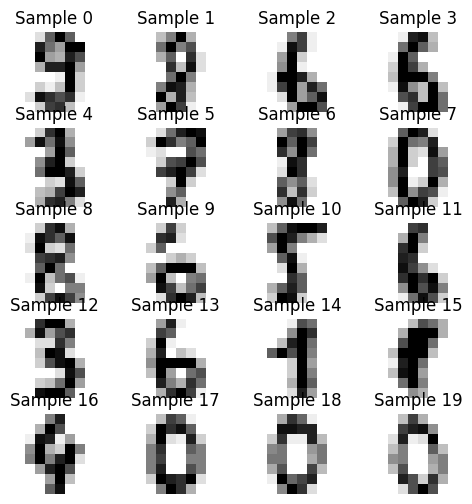

In [27]:
from sklearn import datasets

# загрузим датасет Digits. Он состоит из рукописных изображений цифр
digits = datasets.load_digits().images

# выберем 20 случайных изображений
digits = np.random.permutation(digits)[:20]

# вот они
_, axes = plt.subplots(nrows=5, ncols=4, figsize=(6, 6))
for i, (ax, image) in enumerate(zip(axes.flatten(), digits)):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Sample {i}')

In [28]:
# каждое изображение – матрица размера (8, 8). Давайте вытянем ее в вектор признаков
XX = digits.reshape((digits.shape[0], -1))

**Кластеризуйте вектора и постройте дендрограмму. Какие выводы можно из нее сделать?**


[[17.         18.         14.79864859  2.        ]
 [ 7.         20.         20.54718704  3.        ]
 [ 9.         13.         20.76053949  2.        ]
 [ 4.         12.         22.24859546  2.        ]
 [ 2.         11.         23.47338919  2.        ]
 [19.         21.         24.66429615  4.        ]
 [ 3.         24.         26.32398496  3.        ]
 [ 1.          6.         33.01514804  2.        ]
 [ 8.         27.         37.30800417  3.        ]
 [22.         26.         39.24999083  5.        ]
 [15.         28.         41.18945276  4.        ]
 [ 0.         25.         41.8367924   5.        ]
 [14.         16.         43.52011029  2.        ]
 [10.         30.         45.94035855  5.        ]
 [23.         29.         47.61053994  7.        ]
 [ 5.         33.         48.29306419  6.        ]
 [32.         35.         48.63625462  8.        ]
 [31.         34.         49.15276181 12.        ]
 [36.         37.         50.38482038 20.        ]]


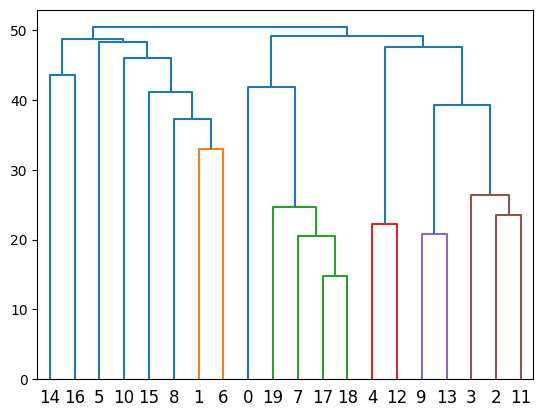

In [29]:
Z = linkage(distance_matrix(XX))
print(np.array(Z))
_ = dendrogram(Z)

**Выводы:**

Как видно из дендаграммы более похожие изображения действительно объединятся в общие класстеры раньше. Так, на первых двух итерациях в один кластер попадают 17, 18 и 7 изображения на которых можно легко разобрать "0". После 4 итерации объединятся все изображения соответсвующие "3" (4 и 12), после 6 - "0" (17, 18, 7, 19) и т. д. Можно заметить, что 15 изображение на 11 итерации присоединяется к кластеру "8", оно действительно напоминает больше эту цифру, но так как изображение сильно искажено, его расстояние до кластера больше и почти равно расстоянию от кластера "9" до кластера "0", поэтому оно присоединяется на более поздних итерациях. То же самое и с "6" которые объединяются на 10 итерации так как имеют на картинке разные наклоны. С 12 итерации начинают объединятся кластеры, соответствующие разным цифрам. Из дендаграммы видно что с этого момента растояния между объединяемыми кластерами растут медленнее так как все кластеры далеки друг от друга и разница становится не так велика.